In [174]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [166]:
bond_list = pd.read_excel('Bonds_list.xlsx')
#as_of_date=pd.Timestamp.today()
as_of_date = pd.to_datetime('2023-07-2')
bond_list 

,Bond_id,type,market_price,notional,expiry_date,coupon,Days in year convention,next_coupon_date,annual_coupon_frequency
0,1,T-bill,99.5,100,2023-10-01,0.00,360,NaT,0
1,2,T-bill,97.5,100,2024-07-01,0.00,360,NaT,0
2,3,T-bond,100.0,100,2024-12-01,0.03,365,2023-12-01,2
3,4,T-bond,102.0,100,2025-05-01,0.04,365,2023-11-01,2


In [167]:
def tBillYtm(market_price, notional, expiry_date, as_of_date, days_in_year=360):
    maturity_days=(expiry_date-as_of_date).days
    ytm = -np.log(market_price/notional)/(maturity_days/days_in_year)
    return ytm, expiry_date

In [168]:
def tBondYtm(market_price, notional, expiry_date, as_of_date, days_in_year, annual_coupon_frequency, coupon, next_coupon_date, yields_table):
    
    # bond payment schedule
    date_index = pd.date_range(start=next_coupon_date, end=expiry_date+pd.DateOffset(1), freq=pd.DateOffset(months=12/annual_coupon_frequency))
    bond_cashflows = pd.DataFrame(index=date_index)
    #bond_cashflows['Coupons'] = 0
    bond_cashflows['Coupons']  = coupon*notional/annual_coupon_frequency
    bond_cashflows['Notional'] = 0
    bond_cashflows['Notional'].iloc[-1] = notional

    #adding zc_rate:
    bond_cashflows=pd.concat([bond_cashflows, yields_table], axis=1).reindex(bond_cashflows.index) # if dates match exactly in yields table and bond_cashflows
    
    # if dates don't match exactly in yields table and bond_cashflows, we will use linear interpolation:
    for i in range(len(bond_cashflows)-1):
        for j in range(len(yields_table)):
            if yields_table.index[j] < bond_cashflows.index[i] < yields_table.index[j+1]:
                bond_cashflows['zc_rate'].iloc[i] = yields_table['zc_rate'].iloc[j] + (yields_table['zc_rate'].iloc[j+1]-yields_table['zc_rate'].iloc[j])*((bond_cashflows.index[i]-yields_table.index[j]).days/(yields_table.index[j+1]-yields_table.index[j]).days) #linear interpolation

    
    bond_cashflows['maturity']=(bond_cashflows.index-as_of_date).days/days_in_year
    bond_cashflows['coupon_PV']=bond_cashflows['Coupons']*np.exp(-bond_cashflows['zc_rate']*bond_cashflows['maturity'])
    ytm2=-np.log((market_price-bond_cashflows['coupon_PV'].sum())/(bond_cashflows['Notional'].iloc[-1]+bond_cashflows['Coupons'].iloc[-1]))/(bond_cashflows['maturity'].iloc[-1])

    print(bond_cashflows)

    return ytm2, expiry_date

In [169]:
# computing zero rates implied from T-bills prices and adding them to yields_table
yields_table=pd.DataFrame(columns=['zc_rate'])
for i in range(len(bond_list)):
    if bond_list['type'].iloc[i] == 'T-bill': #alternatively, it could be if bond_list['coupon'].iloc[i] == 0:
        ytm1, expiry_date1 = tBillYtm(market_price=bond_list['market_price'].iloc[i], notional=bond_list['notional'].iloc[i], expiry_date=bond_list['expiry_date'].iloc[i], as_of_date=as_of_date, days_in_year=bond_list['Days in year convention'].iloc[i])
        s=pd.Series({'zc_rate':ytm1})
        s.name=expiry_date1
        yields_table=yields_table.append(s)
yields_table

C:\Users\a.muslimov\AppData\Local\Temp\ipykernel_7628\4282917578.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  yields_table=yields_table.append(s)
C:\Users\a.muslimov\AppData\Local\Temp\ipykernel_7628\4282917578.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  yields_table=yields_table.append(s)


,zc_rate
2023-10-01,0.019830
2024-07-01,0.024971


In [170]:
# computing zero rates implied from T-bonds prices (with zero rates for coupons already computed from T-bills) and adding them to yields_table
for i in range(len(bond_list)):
    if bond_list['coupon'].iloc[i] >0:
        ytm3, exp_date3 = tBondYtm(market_price=bond_list['market_price'].iloc[i], 
                notional=bond_list['notional'].iloc[i], 
                expiry_date=bond_list['expiry_date'].iloc[i], 
                as_of_date=as_of_date, 
                days_in_year=bond_list['Days in year convention'].iloc[i], 
                annual_coupon_frequency=bond_list['annual_coupon_frequency'].iloc[i], 
                coupon=bond_list['coupon'].iloc[i], 
                next_coupon_date=bond_list['next_coupon_date'].iloc[i], 
                yields_table=yields_table)

        #adding a new zc_rate to the table
        s=pd.Series({'zc_rate':ytm3})
        s.name=exp_date3
        yields_table=yields_table.append(s)
yields_table

            Coupons  Notional   zc_rate  maturity  coupon_PV
2023-12-01      1.5       0.0  0.020974  0.416438   1.486955
2024-06-01      1.5       0.0  0.024408  0.917808   1.466771
2024-12-01      1.5     100.0       NaN  1.419178        NaN
            Coupons  Notional   zc_rate  maturity  coupon_PV
2023-11-01      2.0       0.0  0.020411  0.334247   1.986401
2024-05-01      2.0       0.0  0.023826  0.832877   1.960702
2024-11-01      2.0       0.0  0.030314  1.336986   1.920561
2025-05-01      2.0     100.0       NaN  1.832877        NaN


C:\Users\a.muslimov\AppData\Local\Temp\ipykernel_7628\1881704916.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bond_cashflows['Notional'].iloc[-1] = notional
C:\Users\a.muslimov\AppData\Local\Temp\ipykernel_7628\3507145632.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  yields_table=yields_table.append(s)
C:\Users\a.muslimov\AppData\Local\Temp\ipykernel_7628\1881704916.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bond_cashflows['Notional'].iloc[-1] = notional
C:\Users\a.muslimov\AppData\Local\Temp\ipykernel_7628\3

,zc_rate
2023-10-01,0.019830
2024-07-01,0.024971
2024-12-01,0.031618
2025-05-01,0.032325


(0.0, 0.07)

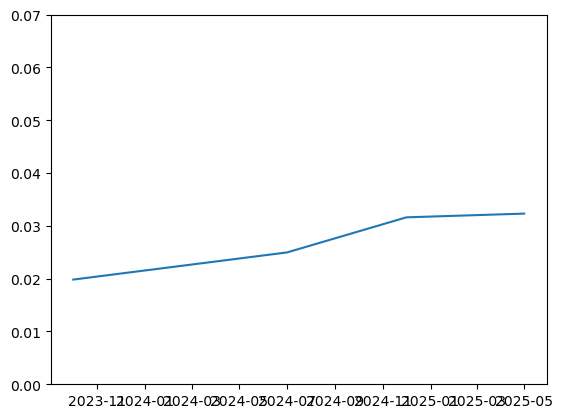

In [175]:
plt.plot(yields_table)
plt.ylim(top=0.07) #ymax is your value
plt.ylim(bottom=0) #ymin is your value

In [172]:
#pip install pandas-datareader

In [173]:
#import pandas_datareader as pdr
#pdr.get_data_fred('GS10')